In [ ]:
```

```

In [0]:
# Modules to ignore warnings
import warnings               
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import os   
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import call

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
train_path = '/content/drive/My Drive/Colab Notebooks/10_categories'   # Train data path
classes = os.listdir(train_path)                          # List of directories in train path
print(classes)

['car_side', 'watch', 'Faces_easy', 'airplanes', 'Leopards', 'Motorbikes', 'BACKGROUND_Google', 'Faces', 'bonsai', 'grand_piano']


In [5]:
for ix,i in enumerate(classes):
    print(i,"\n",len(os.listdir(os.path.join(train_path,i))))

car_side 
 712
watch 
 823
Faces_easy 
 731
airplanes 
 828
Leopards 
 775
Motorbikes 
 798
BACKGROUND_Google 
 759
Faces 
 730
bonsai 
 708
grand_piano 
 689


In [6]:
# This is the augmentation configuration we will use for training
data_generator = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=20,
                                    height_shift_range=0.2,
                                    validation_split = 0.2,
                                    zoom_range=0.2)

# This is a generator that will read pictures found in subfolers of 'train', and generates
# batches of augmented image data on the fly
train_generator = data_generator.flow_from_directory(directory=train_path,
                                                   # batch_size=64, 
                                                    class_mode='categorical', 
                                                    shuffle=True,
                                                    subset = "training",
                                                    target_size=(299, 299))

val_generator = data_generator.flow_from_directory(directory=train_path,
                                                   # batch_size=64,
                                                    class_mode='categorical', 
                                                    shuffle=True,
                                                    subset = "validation",
                                                    target_size=(299, 299))

Found 6046 images belonging to 10 classes.
Found 1506 images belonging to 10 classes.


In [0]:
from keras.applications.xception import Xception

def model_tl(nb_classes, freez_wts):
    
    trained_model = Xception(include_top=False,weights='imagenet', input_shape = (299, 299, 3))
    x = trained_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    pred_inception= Dense(nb_classes,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_inception)
    
    for layer in trained_model.layers:
        layer.trainable=(1-freez_wts)
    
    return(model)
  

In [8]:
model = model_tl(nb_classes=10, freez_wts=False)
 
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='Adadelta')

83689472/83683744 [==============================] - 1s 0us/step


In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

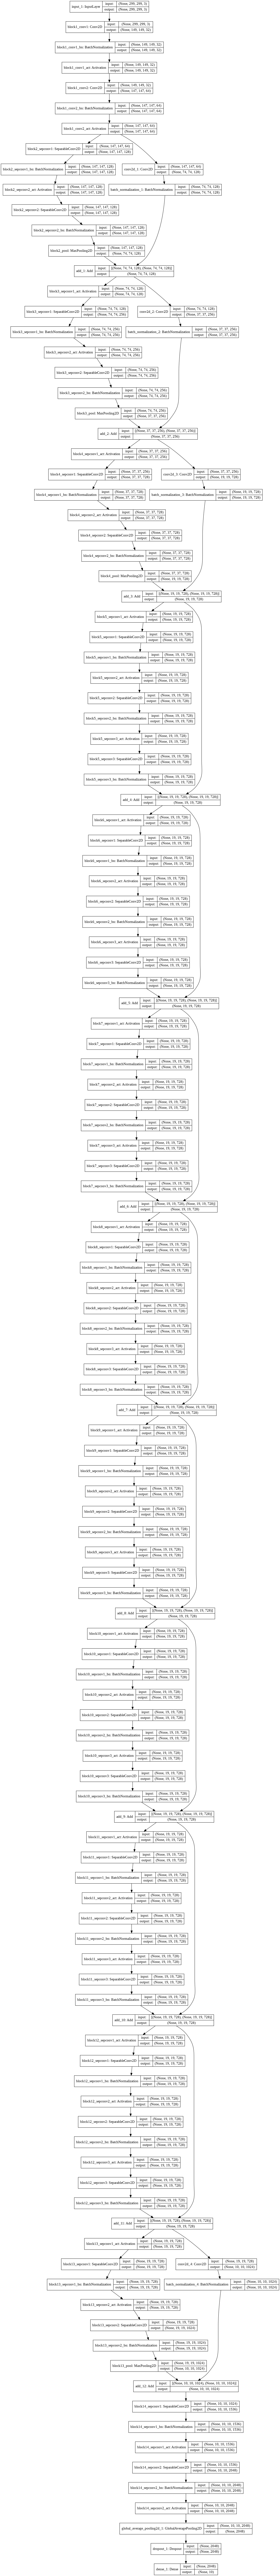

In [10]:
from keras.utils import plot_model
plot_model(model, to_file='Xception.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image("Xception.png")

In [11]:
chkp = ModelCheckpoint(filepath='Xception_tl.h5', monitor='val_acc', save_best_only=True, save_weights_only=False, verbose=0)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = train_generator.samples/train_generator.batch_size,
                              
                              validation_data = val_generator, 
                              validation_steps = val_generator.samples/val_generator.batch_size,
                              callbacks= [chkp],
                              epochs=7, verbose= 1 ,shuffle = True).history

Epoch 1/7
189/188 [==============================] - 2477s 13s/step - loss: 0.1411 - acc: 0.9593 - val_loss: 0.0513 - val_acc: 0.9854
Epoch 2/7
189/188 [==============================] - 261s 1s/step - loss: 0.0351 - acc: 0.9907 - val_loss: 0.0666 - val_acc: 0.9834
Epoch 3/7
189/188 [==============================] - 260s 1s/step - loss: 0.0188 - acc: 0.9949 - val_loss: 0.1302 - val_acc: 0.9635
Epoch 4/7
189/188 [==============================] - 261s 1s/step - loss: 0.0172 - acc: 0.9960 - val_loss: 0.0380 - val_acc: 0.9920
Epoch 5/7
189/188 [==============================] - 261s 1s/step - loss: 0.0071 - acc: 0.9987 - val_loss: 0.0281 - val_acc: 0.9934
Epoch 6/7
189/188 [==============================] - 260s 1s/step - loss: 0.0094 - acc: 0.9974 - val_loss: 0.0245 - val_acc: 0.9914
Epoch 7/7
189/188 [==============================] - 259s 1s/step - loss: 0.0063 - acc: 0.9988 - val_loss: 0.0523 - val_acc: 0.9900


In [12]:
max(history['val_acc'])

0.9933598937583001

Text(0.5, 1.0, 'Accuracy')

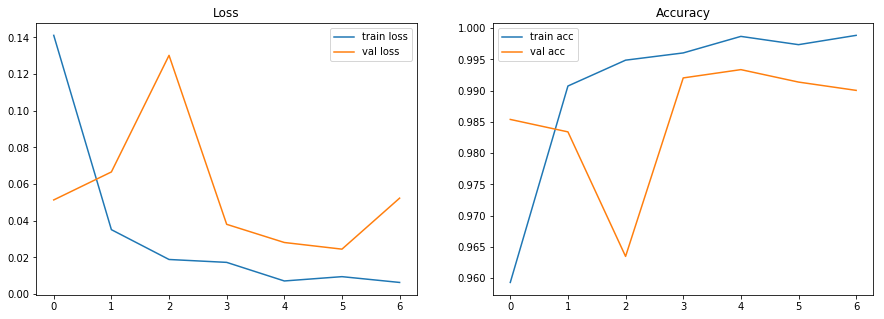

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
train_loss = plt.plot(history['loss'], label='train loss')
val_loss = plt.plot(history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
train_loss = plt.plot(history['acc'], label='train acc')
val_loss = plt.plot(history['val_acc'], label='val acc')
plt.legend()
plt.title('Accuracy')